In [38]:
import numpy as np
import astropy
import matplotlib.pyplot as plt
from astropy.table import Table, QTable, vstack
from astropy.coordinates import match_coordinates_sky, SkyCoord, Distance
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM, Planck15

get_ipython().run_line_magic('matplotlib', 'inline')

Reading fits files and matching:

In [39]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

spt1 = Table.read('2500d_cluster_sample_Bocquet19.fits', format = 'fits')
spt2 = Table.read('sptecs_catalog_oct919.fits', format = 'fits')
spt = vstack([spt1, spt2], join_type='inner')
rm = Table.read('y3_gold_2.2.1_wide_sofcol_run2_redmapper_v6.4.22+2_lgt20_vl50_catalog.fit', format = 'fits')

spt_id, spt_z = spt['SPT_ID'], spt['REDSHIFT']
spt_ra_dec = SkyCoord(ra = spt['RA'] * u.degree, dec = spt['DEC'] * u.degree, distance = Distance(z = spt_z, cosmology = cosmo))

rm_id, rm_z, rm_chisq = rm['MEM_MATCH_ID'], rm['Z_LAMBDA'], np.array(rm['LAMBDA_CHISQ'])
rm_ra_dec = SkyCoord(ra = rm['RA'] * u.degree, dec = rm['DEC'] * u.degree, distance = Distance(z = rm_z, cosmology = cosmo))


spt = QTable([spt_id, spt_ra_dec, spt_z], names = ('id', 'ra, dec', 'z'))
rm = QTable([rm_id, rm_ra_dec, rm_z], names = ('id', 'ra, dec', 'z'))


idx, sep2d, dist3d = match_coordinates_sky(rm['ra, dec'], spt['ra, dec']) #the order counts, len(rm)>>len(spt)
zdist = abs(spt['z'][idx]-rm['z'])

bln = (sep2d.arcmin < 10) & (zdist < 0.1)
matches_raw = {'rm_spt_ids':   np.column_stack((np.where(bln)[0], idx[bln])), 
               'sep2d_arcmin': sep2d[bln].arcmin, 
               'z':            rm['z'][bln], 
               'arcmin_to_mpc':  Planck15.arcsec_per_kpc_comoving(zdist[bln]).to(u.arcmin/u.Mpc).value }
rm_m_ids, spt_m_ids = matches_raw['rm_spt_ids'].T
rm_m_chisq = rm_chisq[bln]

matches = {'rm_spt_ids':[], 'sep2d_arcmin':[], 'z': [], 'dist_Mpc':[]}
for i in range(len(spt_m_ids)):
    result = np.where(spt_m_ids == spt_m_ids[i])[0]
    if len(result)==1:
        matches['rm_spt_ids'].append(list(matches_raw['rm_spt_ids'][result[0]]))
        matches['sep2d_arcmin'].append(matches_raw['sep2d_arcmin'][result[0]]) 
        matches['z'].append(matches_raw['z'][result[0]])
        matches['dist_Mpc'].append(matches_raw['sep2d_arcmin'][result[0]]/matches_raw['arcmin_to_mpc'][result[0]])
    if len(result)>1:
        rm_new_m = rm_m_ids[result[np.where(np.array(rm_m_chisq[result]) == np.amax(np.array(rm_m_chisq[result])))]]
        new_id = np.where(matches_raw['rm_spt_ids'] == rm_new_m)[0][0]
        matches['rm_spt_ids'].append(list(matches_raw['rm_spt_ids'][new_id]))
        matches['sep2d_arcmin'].append(matches_raw['sep2d_arcmin'][new_id]) 
        matches['z'].append(matches_raw['z'][new_id])
        matches['dist_Mpc'].append(matches_raw['sep2d_arcmin'][new_id]/matches_raw['arcmin_to_mpc'][new_id])        

spt_ids = np.array(matches['rm_spt_ids']).T[1]
spt_z_m = np.array(spt['z'][spt_ids])

offset = np.array(matches['dist_Mpc'])
offset_err = np.sqrt(np.sum(offset**2)/len(offset))

Plot:

(-10, 1119)

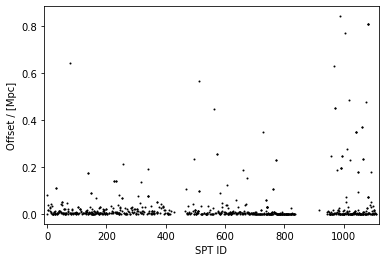

In [40]:
plt.errorbar(spt_ids, offset, fmt = 'k.', ms = 2)
plt.ylabel(r'Offset / [Mpc]')
plt.xlabel(r'SPT ID')
plt.xlim(-10, max(spt_ids) + 10)

Text(0.5, 0, 'SPT z')

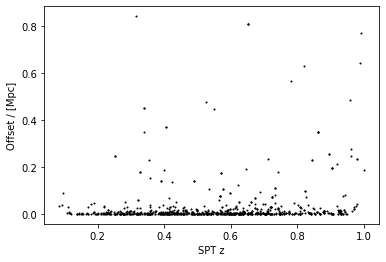

In [41]:
plt.errorbar(spt_z_m, offset, fmt = 'k.', ms = 2)
plt.ylabel(r'Offset / [Mpc]')
plt.xlabel(r'SPT z')

Text(0, 0.5, '$\\mathrm{N} / \\mathrm{N}_{tot}$')

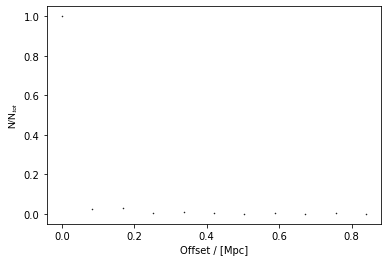

In [42]:
nbin = 10
bins = np.zeros((nbin) + 1)

bin_width = (max(offset) - min(offset)) / nbin
for i in range(len(offset)):
    bins[int(offset[i] / bin_width)] += 1
bins = bins / max(bins)

plt.plot(bin_width * range(len(bins)), bins, 'k.', ms = 1)
plt.xlabel(r'Offset / [Mpc]')
plt.ylabel(r'$\mathrm{N} / \mathrm{N}_{tot}$')

# Rayleigh Distribution:
$$P(x) = \frac{x}{\sigma^2}\mathrm{e}^{-0.5({x}/{\sigma})^2} \text{ and } \log(P(x)) = -2\log(\sigma) - \frac{x^2}{2\sigma ^2} + \log(x)$$



In [43]:
def log_prior(sigma):
    if np.all(sigma) > 0:
        return 0.0
    return -np.inf

def log_likelihood(sigma, x):
    log_l = np.sum(- 2 * np.log(sigma) - 0.5 * (x / sigma)**2 + np.log(x))
    return log_l

def log_posterior(sigma, x):
    log_prio = log_prior(sigma)
    if not np.isfinite(log_prio):
        return - np.inf
    log_like = log_likelihood(sigma, x)
    log_post = log_like + log_prio
    return log_post


import emcee

sigma_arr = offset_err + 0.1 * np.random.random((16, 1)) 

nwalkers, ndim = sigma_arr.shape


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[offset])
sampler.run_mcmc(sigma_arr, 2000, progress = True)

100%|██████████| 2000/2000 [00:16<00:00, 120.98it/s]


State([[0.07050563]
 [0.07321248]
 [0.07090159]
 [0.06947527]
 [0.06876756]
 [0.07207272]
 [0.07074957]
 [0.06958497]
 [0.06899848]
 [0.07201933]
 [0.06830645]
 [0.06988868]
 [0.07124127]
 [0.07118061]
 [0.07038114]
 [0.07165824]], log_prob=[-1196.44142786 -1198.79979548 -1196.51888155 -1196.70887362
 -1197.30556215 -1197.2987954  -1196.47766439 -1196.64715445
 -1197.07255561 -1197.2459573  -1197.88498002 -1196.51820677
 -1196.66178992 -1196.63117564 -1196.43731009 -1196.93117665], blobs=None, random_state=('MT19937', array([2052719732, 3704814029,  820652970, 2707937346, 1335497396,
       4029291475, 3743504763, 3141263872,  767982562, 2602210167,
       2806082954, 1299768495, 2616530181,  951450007,  519220373,
       3971237173, 1093220408,  902285457, 3698717477, 2025883713,
        507716376, 2120536154, 1762179093,  582666987, 1213505836,
       1385706980, 1683967360, 3081146155, 1464887662, 3620369470,
       2885170144, 2262913970, 3449225006, 3715696936, 1298680537,
       

Tau =  [15.5013055]
Sigma_max_likelihood =  0.07070757286026952


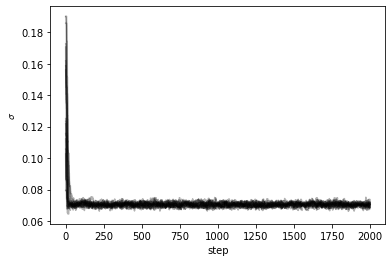

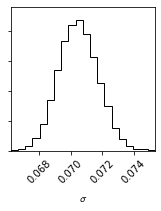

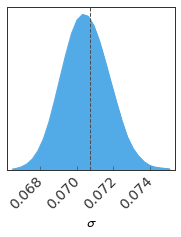

In [44]:
sample = sampler.get_chain()

label = [r'$\sigma$']
plt.plot(sample[:,:,0], "k", alpha=0.3)
plt.ylabel(label[0])
plt.xlabel('step')

tau = sampler.get_autocorr_time()
print('Tau = ', tau)
flat_samples = sampler.get_chain(discard=100, flat=True)
flat_blob = sampler.get_blobs(flat=True,discard=100)

Max_likelihood = np.argmax(flat_blob)
sigma_ml = flat_samples[Max_likelihood,:][0]
print('Sigma_max_likelihood = ', sigma_ml)

import corner, pygtc
fig = corner.corner(flat_samples, labels=label)

GTC = pygtc.plotGTC(chains = flat_samples, paramNames = label, figureSize = 3, 
                    holdRC = True, customLabelFont = {'size':14}, 
                    customTickFont = {'size':14}, truths = flat_samples[Max_likelihood,:])

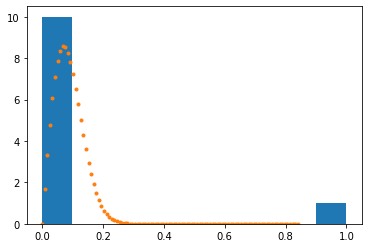

In [45]:
plt.hist(bins)

x = np.linspace(min(offset), max(offset), 100)
plt.plot(x, x * np.exp(-0.5 * (x/sigma_ml)**2) / sigma_ml**2, '.')

# 2 Rayleigh Distributions:
$$P(x|\sigma_0, \sigma_1, p_0) = x (\frac{p_0}{\sigma_0^2}\mathrm{e}^{-0.5({x}/{\sigma_0})^2} + \frac{1 - p_0}{\sigma_1^2}\mathrm{e}^{-0.5({x}/{\sigma_1})^2})$$


In [46]:
def log_prior2(theta):
    sigma_0, delta_sigma, p_0 = theta
    if sigma_0 > 0 and delta_sigma > 0 and 0 < p_0 < 1:
        return 0.0
    return -np.inf

def log_likelihood2(theta, x):
    sigma_0, delta_sigma, p_0 = theta
    sigma_1 = sigma_0 + delta_sigma
    log_l = np.sum(np.log(x * (p_0 * np.exp(- 0.5 * (x / sigma_0)**2) / (sigma_0**2) + (1 - p_0) * np.exp(- 0.5 * (x / sigma_1)**2) / (sigma_1**2))))
    return log_l

def log_posterior2(theta, x):
    log_prio = log_prior2(theta)
    if not np.isfinite(log_prio):
        return - np.inf
    log_like = log_likelihood2(theta, x)
    log_post = log_like + log_prio
    return log_post


sigma_arr2 = [0.1, 0.2, 0.5] + 1e-2 * np.random.random((16, 3))
nwalkers2, ndim2 = sigma_arr2.shape

sampler2 = emcee.EnsembleSampler(nwalkers2, ndim2, log_posterior2, args=[offset])
sampler2.run_mcmc(sigma_arr2, 2000, progress = True)

  4%|▍         | 84/2000 [00:00<00:19, 100.53it/s]/home/andrea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 2000/2000 [00:22<00:00, 89.50it/s]


State([[0.00252461 0.13103044 0.70522269]
 [0.00250602 0.12220792 0.68509789]
 [0.002892   0.12361165 0.7461148 ]
 [0.0028691  0.13709578 0.74750208]
 [0.00265898 0.12983256 0.73564023]
 [0.00259201 0.13187454 0.72077235]
 [0.00278021 0.1340207  0.71667152]
 [0.00280837 0.13282852 0.75014737]
 [0.00293074 0.13912254 0.72097383]
 [0.00263955 0.1220839  0.71592076]
 [0.00288792 0.1345002  0.71445814]
 [0.00258964 0.12861197 0.71550693]
 [0.00265372 0.12705135 0.70840472]
 [0.00270148 0.12919778 0.73932631]
 [0.00283923 0.13063004 0.70536128]
 [0.00253121 0.13473431 0.70286252]], log_prob=[1756.55484246 1755.20954104 1753.97217203 1755.31245771 1756.7339851
 1756.9026362  1756.93046354 1755.67405212 1755.05014351 1756.21018217
 1756.019215   1757.30561719 1757.35343765 1756.59862155 1756.16480391
 1755.66098098], blobs=None, random_state=('MT19937', array([2052719732, 3704814029,  820652970, 2707937346, 1335497396,
       4029291475, 3743504763, 3141263872,  767982562, 2602210167,
       

(2000, 16, 3)


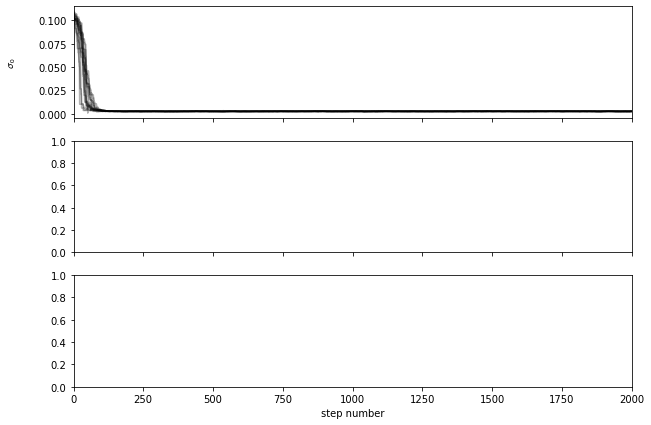

In [47]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples2 = sampler2.get_chain()

print(samples2.shape)
labels = ["$\sigma_0$", "$\Delta\sigma$", "p$_0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples2[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples2))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [48]:
flat_samples = sampler2.get_chain(discard=200, flat=True)
flat_blob = sampler2.get_blobs(flat=True,discard=200)

Max_likelihood2 = np.argmax(flat_blob)
par_ml = flat_samples[Max_likelihood2, :]
print(par_ml)

'''import corner, pygtc
fig = corner.corner(flat_samples, labels=label)

GTC = pygtc.plotGTC(chains = flat_samples, paramNames = label, figureSize = 3, 
                    holdRC = True, customLabelFont = {'size':14}, 
                    customTickFont = {'size':14}, truths = flat_samples[Max_likelihood,:])'''

[0.00285472 0.13310387 0.75070892]


"import corner, pygtc\nfig = corner.corner(flat_samples, labels=label)\n\nGTC = pygtc.plotGTC(chains = flat_samples, paramNames = label, figureSize = 3, \n                    holdRC = True, customLabelFont = {'size':14}, \n                    customTickFont = {'size':14}, truths = flat_samples[Max_likelihood,:])"

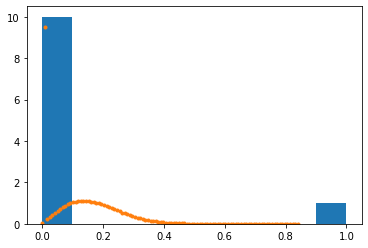

In [58]:
plt.hist(bins)

x = np.linspace(min(offset), max(offset), 100)
sigma_0, delta_sigma, p_0 = par_ml
sigma_1 = sigma_0 + delta_sigma
y = x * (p_0 * np.exp(- 0.5 * (x / sigma_0)**2) / (sigma_0**2) + (1 - p_0) * np.exp(- 0.5 * (x / sigma_1)**2) / (sigma_1**2))
plt.plot(x, y, '.')